In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px

sns.set_theme()

# Functions

In [2]:
# Definisci una funzione per mappare i paesi alle regioni
def assign_region(country):
    country = HDR_ISO_country[country]
    if country in Asia:
        return 'EAP'
    elif country in Europe_Central_Asia:
        return 'ECA'
    elif country in Weastern_Europe:
        return 'WE'
    elif country in North_America:
        return 'NA'
    elif country in Arab_states:
        return 'AS'
    elif country in Oceania:
        return 'OC'
    elif country in Areas:
        return 'AREA'

In [3]:
def Pivoting(df): # Function to pivot the dataframe
    df_r = df.pivot(index=['iso3','hdicode','region','year'], columns='indicator_name', values='value').reset_index()
    df_r.reset_index(inplace=True)
    df_r.columns.name = None
    df_r.drop(columns=['index'], inplace=True)
    df_r['year'] = pd.to_datetime(df_r['year'], format='%Y',errors='coerce').dt.year
    return df_r

In [4]:
def Gap(df: pd.DataFrame, inds: list[str]) -> pd.DataFrame:
    """
    For each iso3, find the overall min and max year in df,
    then for each indicator in inds compute newest – oldest.
    
    Returns a DataFrame with columns:
      iso3, min_year, max_year,
      oldest_<ind>, newest_<ind>, <ind>_diff  (one set per indicator)
    """
    # 1) Find global min and max year per country
    year_range = (
        df.groupby('iso3')['year']
          .agg(min_year='min', max_year='max')
          .reset_index()
    )
    
    # 2) Pull out oldest rows
    oldest = (
        df.merge(year_range, on='iso3')
          .query("year == min_year")
          .loc[:, ['iso3', 'year'] + inds]
          .rename(columns={ 'year': 'min_year', 
                            **{ind: f'oldest_{ind}' for ind in inds}})
    )
    
    # 3) Pull out newest rows
    newest = (
        df.merge(year_range, on='iso3')
          .query("year == max_year")
          .loc[:, ['iso3', 'year'] + inds]
          .rename(columns={ 'year': 'max_year', 
                            **{ind: f'newest_{ind}' for ind in inds}})
    )
    
    # 4) Merge them all together
    result = (
        year_range
        .merge(oldest, on='iso3')
        .merge(newest, on='iso3')
    )
    
    # 5) Compute diffs
    for ind in inds:
        result[f'{ind}_diff'] = result[f'newest_{ind}'] - result[f'oldest_{ind}']
    
    return result

# Example usage:
# df has columns ['iso3','year','logGDP','pop','ind1',...]
# gaps = Gap(df, ['logGDP','pop'])


In [5]:
def PrepareData(df,ind): # Function to prepare the data for analysis
    Panel = df.copy()
    shift = ind.replace('_value', '') + '_shifted'
    Panel[shift] = Panel.groupby('iso3')[ind].shift(1)
    Panel.dropna(subset = shift ,inplace=True) # Drop rows with NaN values
    return Panel

In [6]:
def Regression(Panel,independent_vars,dependent_var): # Function to run the regression
    L = ['iso3','year']
    L.extend(independent_vars)
    L.append(dependent_var)
    model_df = Panel[L].copy()
    model_df = model_df.set_index(['iso3', 'year'])
    # Drop rows with NaN values only in the independent and dependent variable columns
    model_df = model_df.dropna(subset=independent_vars + [dependent_var])
    model_df[independent_vars] = model_df[independent_vars].apply(pd.to_numeric, errors='coerce')
    model_df[dependent_var] = model_df[dependent_var].apply(pd.to_numeric, errors='coerce')

    Y = model_df[dependent_var]
    X = model_df[independent_vars]
    X = sm.add_constant(X)

    mod_fe = PanelOLS(Y,X, entity_effects=True, time_effects=True)
    results = mod_fe.fit(cov_type='clustered',cluster_entity=True)

    return results.summary

In [7]:
def GapShared(df1: pd.DataFrame, ind1: str,
              df2: pd.DataFrame, ind2: str) -> pd.DataFrame:
    """
    For each iso3, find the overlapping year range between df1 and df2,
    then compute for both indicators at the start and end of that range:
      - <ind>_start, <ind>_end, <ind>_diff
    Returns a DataFrame with columns:
      iso3, common_start_year, common_end_year,
      start_<ind1>, end_<ind1>, diff_<ind1>,
      start_<ind2>, end_<ind2>, diff_<ind2>
    """
    # 1) Compute min/max years per iso3 in each dataset
    df1 = df1.dropna(subset=[ind1])
    df2 = df2.dropna(subset=[ind2])
    y1 = df1.groupby('iso3')['year'].agg(min1='min', max1='max').reset_index()
    y2 = df2.groupby('iso3')['year'].agg(min2='min', max2='max').reset_index()

    # 2) Merge to get per-iso3 common span
    yrs = pd.merge(y1, y2, on='iso3', how='inner')
    yrs['common_start_year'] = yrs[['min1', 'min2']].max(axis=1)
    yrs['common_end_year']   = yrs[['max1', 'max2']].min(axis=1)

    # 3) Filter to only those with a valid overlap
    valid = yrs[yrs['common_start_year'] <= yrs['common_end_year']]

    # 4) Prepare df1 oldest and newest at shared years
    df1_ext = pd.merge(df1, valid[['iso3', 'common_start_year', 'common_end_year']], on='iso3')
    oldest1 = df1_ext[df1_ext['year'] == df1_ext['common_start_year']][['iso3', ind1]]
    newest1 = df1_ext[df1_ext['year'] == df1_ext['common_end_year']][['iso3', ind1]]
    oldest1 = oldest1.rename(columns={ind1: f'start_{ind1}'})
    newest1 = newest1.rename(columns={ind1: f'end_{ind1}'})

    # 5) Prepare df2 oldest and newest at shared years
    df2_ext = pd.merge(df2, valid[['iso3', 'common_start_year', 'common_end_year']], on='iso3')
    oldest2 = df2_ext[df2_ext['year'] == df2_ext['common_start_year']][['iso3', ind2]]
    newest2 = df2_ext[df2_ext['year'] == df2_ext['common_end_year']][['iso3', ind2]]
    oldest2 = oldest2.rename(columns={ind2: f'start_{ind2}'})
    newest2 = newest2.rename(columns={ind2: f'end_{ind2}'})

    # 6) Merge all parts
    result = valid[['iso3', 'common_start_year', 'common_end_year']]
    result = result.merge(oldest1, on='iso3')
    result = result.merge(newest1, on='iso3')
    result[f'diff_{ind1}'] = result[f'end_{ind1}'] - result[f'start_{ind1}']

    result = result.merge(oldest2, on='iso3')
    result = result.merge(newest2, on='iso3')
    result[f'diff_{ind2}'] = result[f'end_{ind2}'] - result[f'start_{ind2}']

    return result


In [38]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data

In [ ]:
def calculate_vif(df: pd.DataFrame) -> pd.Series:
    """
    Calculate VIF for each column in df.
    Returns a pd.Series indexed by column names.
    """
    vif = pd.Series(
        [variance_inflation_factor(df.values, i) for i in range(df.shape[1])],
        index=df.columns,
        name="VIF"
    )
    return vif

def vif_selection(
    X: pd.DataFrame,
    thresh: float = 10.0,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Recursively drop the feature with the highest VIF until all VIFs <= thresh.

    Parameters
    ----------
    X : pd.DataFrame
        The design matrix (should be scaled if you want to include intercept)
    thresh : float, default 10.0
        VIF threshold. Variables with VIF > thresh will be removed.
    verbose : bool, default True
        If True, prints each dropped feature and its VIF.

    Returns
    -------
    pd.DataFrame
        Subset of X with all VIFs <= thresh.
    """
    # Work on a copy so we don't modify the original
    X = X.copy()
    # If you’ve already added an intercept column, drop it before VIF calc
    if 'Intercept' in X.columns:
        X = X.drop(columns='Intercept')

    # Calculate current VIFs
    vif = calculate_vif(X)
    max_vif = vif.max()

    # Base case: all VIFs below threshold
    if max_vif <= thresh:
        if verbose:
            print("All VIFs are below threshold.")
        return X

    # Otherwise drop the worst offender and recurse
    worst_feature = vif.idxmax()
    if verbose:
        print(f"Dropping '{worst_feature}' (VIF = {max_vif:.2f})")
    X = X.drop(columns=worst_feature)

    return vif_selection(X, thresh=thresh, verbose=verbose)

In [ ]:
def pvalue_selection(
    X: pd.DataFrame,
    y: pd.Series,
    thresh: float = 0.05,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Iteratively drops the predictor with the highest p-value until
    all predictors have p-value <= thresh.

    Parameters
    ----------
    X : pd.DataFrame
        Predictor matrix (not including the constant).
    y : pd.Series
        Response variable.
    thresh : float, default 0.05
        Maximum allowed p-value.
    verbose : bool, default True
        If True, prints each dropped variable and its p-value.

    Returns
    -------
    pd.DataFrame
        Subset of X whose OLS p-values are all <= thresh (plus a constant column).
    """
    X = X.copy()
    # always include constant in the model
    X_const = sm.add_constant(X, has_constant='add')

    while True:
        model = sm.OLS(y, X_const).fit()
        pvals = model.pvalues.drop('const', errors='ignore')  # ignore intercept
        max_p = pvals.max()

        # if the worst p-value is within threshold, we’re done
        if max_p <= thresh:
            if verbose:
                print("All predictors have p-value ≤", thresh)
            break

        # otherwise drop the predictor with the largest p-value
        worst = pvals.idxmax()
        if verbose:
            print(f"Dropping '{worst}' (p = {max_p:.4f})")
        X_const = X_const.drop(columns=[worst])

    return X_const



# Data loading and preparation

## Data Loading

In [8]:
path = 'Datasets/'
image_path = '/Users/gianlucafilesi/Library/CloudStorage/OneDrive-EDHEC/04 THESIS/Images/Results/'

gdp_pc_ppp = pd.read_csv(path + 'GDP per capita, PPP (current international)/WB_WDI_NY_GDP_PCAP_PP_CD.csv') # GDP per capita, PPP (current international $)
hdr = pd.read_csv(path + 'HDR/HDR25_Composite_indices_complete_time_series.csv',encoding='latin1') # Human Development Index
hdr_labels = pd.read_excel(path + 'HDR/HDR25_Composite_indices_metadata.xlsx', sheet_name = 'codebook') # Human Development
schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data
schooling_labels = pd.read_csv(path+'UNESCO/OPRI_LABEL.csv') # Schooling labels
gs = pd.read_csv(path + 'GenderStatistics/GS.csv') # Globalization data

/var/folders/pl/qxmk8x1d1m586z4_j013bvqw0000gn/T/ipykernel_3110/247098959.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  schooling = pd.read_csv(path+'UNESCO/OPRI_DATA_NATIONAL.zip', dtype={'INDICATOR_ID': 'object'}, compression='zip')  # Schooling data


## Data preparation

In [9]:
GS = gs.copy()
GS = GS.drop(columns=['Unnamed: 0'])
GS = GS.rename(columns={'REF_AREA': 'iso3', 'YEAR': 'year'})

### HDR

In [10]:
HDR_ISO_country = {hdr['iso3'][i]:hdr['country'][i] for i in range(len(hdr))}

In [11]:
hdr_labels.drop(columns=['Time series'], inplace=True)
hdr_labels.dropna(subset=['Short name'], inplace=True)
hdr_labels.rename(columns={'Full name': 'indicator_name', 'Short name': 'indicator'}, inplace=True)

In [12]:
HDR = hdr.copy()
df_melted = HDR.melt(id_vars=['iso3', 'country', 'hdicode', 'region', 'hdi_rank_2023'], var_name='indicator_year', value_name='value') # Melt the dataframe to long format
df_melted[['indicator', 'year']] = df_melted['indicator_year'].str.extract(r'([a-z0-9_]+)_(\d{4})')
df_final = df_melted[['iso3','hdicode','region','year', 'indicator', 'value']] # Reorder and select final columns
HDR = pd.merge(hdr_labels, df_final, on=['indicator'], how='right') # Merge with labels

In [13]:
North_America = ['Canada','United States'] 
Oceania = ['Australia','New Zealand'] 
Asia = ['Hong Kong, China (SAR)','Korea (Republic of)','Japan'] 
Europe_Central_Asia = ['Cyprus','Russian Federation','Israel'] 
Weastern_Europe = ['Andorra', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark', 
                   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 
                   'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 
                   'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'San Marino', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland','United Kingdom']
Arab_states = ['Algeria', 'Bahrain', 'Djibouti', 'Egypt', 'Iraq', 'Jordan']
Areas = ['Very high human development', 'High human development',
       'Medium human development', 'Low human development', 'Arab States',
       'East Asia and the Pacific', 'Europe and Central Asia',
       'Latin America and the Caribbean', 'South Asia',
       'Sub-Saharan Africa', 'World']

In [14]:
region_labels = {
    'ECA': 'Europe & Central Asia',
    'AS':  'Arab States',
    'SSA': 'Sub-Saharan Africa', 
    'LAC': 'Latin America & Caribbean',
    'SA':  'South Asia',
    'EAP': 'East Asia & Pacific',
    'AS':  'Arab States',
    'NA': 'North America',
    'WE': 'Western Europe',
    'OC': 'Oceania'
}

In [15]:
h = HDR[HDR['region'].isna()].copy()
h.loc[:,'region'] = h.loc[:,'iso3'].apply(assign_region)
HDR = pd.concat([HDR[~HDR['region'].isna()], h], ignore_index=True) # Concatenate the two dataframes
HDR.dropna(subset=['value'], inplace=True) # Drop rows with NaN values in the region column
HDR = HDR[HDR['region'] != 'AREA']

In [16]:
HDI_indicators = ['hdi', 'le', 'eys', 'mys', 'gnipc']
GDI_indicators = ['gdi_group', 'gdi', 'hdi_f', 'le_f', 'eys_f', 'mys_f', 'gni_pc_f', 'hdi_m', 'le_m', 'eys_m', 'mys_m', 'gni_pc_m']
IHDI_indicators = ['ihdi', 'coef_ineq', 'loss', 'ineq_le', 'ineq_edu', 'ineq_inc']
GII_indicators = ['gii_rank', 'gii', 'mmr', 'abr', 'se_f', 'se_m', 'pr_f', 'pr_m', 'lfpr_f', 'lfpr_m']
PHDI_indicators = ['rankdiff_hdi_phdi', 'phdi', 'diff_hdi_phdi', 'co2_prod', 'mf']
Population_indicator = ['pop_total']

In [17]:
hdi = HDR[HDR['indicator'].isin(HDI_indicators+Population_indicator)]
gdi = HDR[HDR['indicator'].isin(GDI_indicators+Population_indicator)]
ihdi = HDR[HDR['indicator'].isin(IHDI_indicators+Population_indicator)]
gii = HDR[HDR['indicator'].isin(GII_indicators+Population_indicator)]
phdi = HDR[HDR['indicator'].isin(PHDI_indicators+Population_indicator)]

In [18]:
HDI = Pivoting(hdi)
GDI = Pivoting(gdi)
IHDI = Pivoting(ihdi)
GII = Pivoting(gii)

In [19]:
HDR_idx = {'hdi': 'Human Development Index (value)', 'gii': 'Gender Inequality Index (value)', 
           'gdi': 'Gender Development Index (value)', 'ihdi': 'Inequality-adjusted Human Development Index (value)'}

#### GDP per Capita PPP

In [20]:
WB_ISO_country = {gdp_pc_ppp['REF_AREA_ID'][i]:gdp_pc_ppp['REF_AREA_NAME'][i] for i in range(len(gdp_pc_ppp))}

In [21]:
GDP = gdp_pc_ppp.copy()
GDP = GDP[['REF_AREA_ID','TIME_PERIOD','OBS_VALUE']]
GDP.rename(columns={'REF_AREA_ID':'iso3','TIME_PERIOD':'year','OBS_VALUE':'GDP'},inplace=True)
GDP['year'] = pd.to_datetime(GDP['year'], format='%Y',errors='coerce').dt.year
GDP['logGDP'] = np.log(GDP['GDP'])

#### Schooling

In [22]:
SCH = schooling.copy()
SCH['INDICATOR_ID'] = SCH['INDICATOR_ID'].astype(str)
SCH = SCH[SCH['INDICATOR_ID'].str.contains('NART', na=False)] 
SCH = SCH.drop(columns=['MAGNITUDE','QUALIFIER'])
SCH = pd.merge(schooling_labels,SCH,how='left',on='INDICATOR_ID') # Merge the labels with the schooling data
SCH['YEAR'] = pd.to_datetime(SCH['YEAR'], format='%Y',errors='coerce').dt.year 

In [23]:
Primary = SCH[SCH['INDICATOR_ID'].str.contains('NART.1', na=False)] # Filter for primary education
Secondary = SCH[SCH['INDICATOR_ID'].str.contains('NART.2', na=False)] # Filter for secondary education
Tertiary = SCH[SCH['INDICATOR_ID'].str.contains('NART.3', na=False)] # Filter for tertiary education

In [24]:
P = Primary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
S = Secondary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()
T = Tertiary.pivot(index=['COUNTRY_ID','YEAR'], columns='INDICATOR_LABEL_EN', values='VALUE').reset_index()

In [25]:
P.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
S.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)
T.rename(columns={'COUNTRY_ID':'iso3','YEAR':'year'}, inplace=True)

# Gap

In [27]:
GAP_GDP_GII = GapShared(GDP, 'logGDP', GII, HDR_idx['gii'])

In [28]:
GAP_GDP_GII_GS = pd.merge(GAP_GDP_GII, GS[GS['year']==2023], how='left', on=['iso3'])

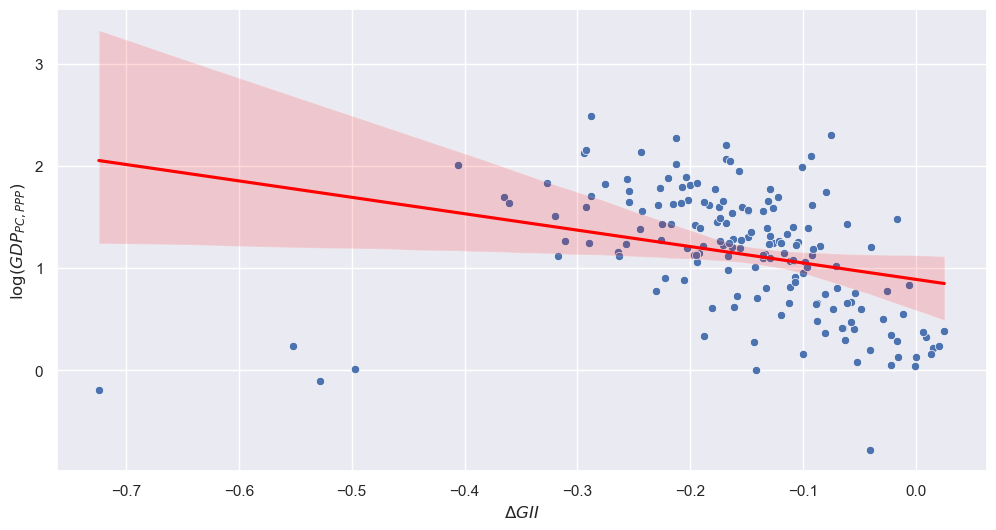

In [56]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=GAP_GDP_GII, y='diff_logGDP', x='diff_Gender Inequality Index (value)')
sns.regplot(data=GAP_GDP_GII, y='diff_logGDP', x='diff_Gender Inequality Index (value)', scatter=False, color='red', line_kws={"label": "Trend Line"})
plt.ylabel(r'$\log (GDP_{PC,PPP})$')
plt.xlabel(r'$\Delta GII$')

# plt.savefig(image_path + 'HDI_Female_vs_Male.pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [57]:
np.corrcoef(GAP_GDP_GII['diff_logGDP'], GAP_GDP_GII['diff_Gender Inequality Index (value)'])

array([[ 1.        , -0.28838465],
       [-0.28838465,  1.        ]])

In [29]:
Panel_GII = GAP_GDP_GII.copy()
Y = Panel_GII['diff_logGDP']
X = Panel_GII['diff_'+HDR_idx['gii']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     15.24
Date:                Wed, 14 May 2025   Prob (F-statistic):           0.000137
Time:                        11:00:46   Log-Likelihood:                -146.44
No. Observations:                 170   AIC:                             296.9
Df Residuals:                     168   BIC:                             303.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.8909      0.078     11.426      0.000       0.737       1.045
diff_Gender Inequality Index (value)    -1.6065      0.412     -3.904      0.000      -2.419      -0.794
==============================================================================
Omnibus:                       23.858   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.650
Skew:                          -0.788   Prob(JB):                     2.99e-08
Kurtosis:                       4.552   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
Panel_GII_GS = GAP_GDP_GII_GS.copy()
Y = Panel_GII_GS['diff_logGDP']
X = Panel_GII_GS
X.drop(columns=['iso3', 'common_start_year', 'common_end_year', 'start_logGDP',
       'end_logGDP', 'diff_logGDP', 'start_Gender Inequality Index (value)',
       'end_Gender Inequality Index (value)','year'],inplace=True)
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     4.005
Date:                Wed, 14 May 2025   Prob (F-statistic):           3.44e-09
Time:                        11:00:46   Log-Likelihood:                -92.971
No. Observations:                 170   AIC:                             257.9
Df Residuals:                     134   BIC:                             370.8
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                -0.1260      0.631     -0.200      0.842      -1.373       1.121
diff_Gender Inequality Index (value)                                                                 -1.4094      0.407     -3.460      0.001      -2.215      -0.604
A woman can apply for a passport in the same way as a man (1=yes; 0=no)                               0.2239      0.130      1.722      0.087      -0.033       0.481
A woman can be head of household in the same way as a man (1=yes; 0=no)                              -0.0364      0.162     -0.224      0.823      -0.357       0.285
A woman can choose where to live in the same way as a man (1=yes; 0=no)                               0.3224      0.150      2.149      0.033       0.026       0.619
A woman can get a job in the same way as a man (1=yes; 0=no)                                         -0.0594      0.234     -0.254      0.800      -0.521       0.402
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)                      -0.0732      0.143     -0.511      0.610      -0.356       0.210
A woman can open a bank account in the same way as a man (1=yes; 0=no)                            -1.682e-05      0.396  -4.24e-05      1.000      -0.784       0.784
A woman can register a business in the same way as a man (1=yes; 0=no)                               -0.2062      0.345     -0.598      0.551      -0.888       0.476
A woman can sign a contract in the same way as a man (1=yes; 0=no)                                    0.2635      0.646      0.408      0.684      -1.015       1.542
A woman can travel outside her home in the same way as a man (1=yes; 0=no)                           -0.0168      0.313     -0.054      0.957      -0.636       0.602
A woman can travel outside the country in the same way as a man (1=yes; 0=no)                         0.2401      0.263      0.912      0.363      -0.280       0.761
A woman can work at night in the same way as a man (1=yes; 0=no)                                      0.0271      0.153      0.177      0.859      -0.275       0.329
A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no)                    -0.1031      0.121     -0.856      0.394      -0.341       0.135
A woman can work in an industrial job in the same way as a man (1=yes; 0=no)                          0.0382      0.108      0.352      0.725      -0.176       0.252
A woman has the same rights to remarry as a man (1=yes; 0=no)                                  

## Multicollinearity

In [35]:
Sigma = Panel_GII_GS.corr(method='pearson').abs()
Sigma.values.diagonal().sum() == len(Panel_GII_GS.columns) # Check if the diagonal is 1
np.fill_diagonal(Sigma.values, np.nan)
Sigma.style.background_gradient(cmap='coolwarm', axis=None)

,diff_Gender Inequality Index (value),A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside her home in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work at night in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),Dismissal of pregnant workers is prohibited (1=yes; 0=no),Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no),Law prohibits discrimination in employment based on gender (1=yes; 0=no),Paid leave is available to fathers (1=yes; 0=no),Paid leave of at least 14 weeks available to mothers (1=yes; 0=no),The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no),The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
diff_Gender Inequality Index (value),nan,0.155925,0.135431,0.066119,0.045301,0.154590,0.114320,0.101726,0.066711,0.157623,0.128254,0.038119,0.007416,0.048774,0.097763,0.107218,0.003919,0.092347,0.023117,0.188122,0.002660,0.058967,0.070901,0.068815,0.126179,0.005313,0.114230,0.175231,0.091838,0.179954,0.197041
A woman can apply for a passport in the same way as a man (1=yes; 0=no),0.155925,nan,0.118610,0.042459,0.049198,0.212039,0.032932,0.052058,0.030427,0.025278,0.016716,0.040129,0.098611,0.062581,0.057586,0.145481,0.232102,0.153482,0.145223,0.271638,0.136462,0.103276,0.058489,0.118969,0.242457,0.058850,0.068111,0.186381,0.122456,0.001783,0.266226
A woman can be head of household in the same way as a man (1=yes; 0=no),0.135431,0.118610,nan,0.446355,0.478714,0.287090,0.409673,0.149679,0.181030,0.265733,0.264471,0.239697,0.333487,0.166434,0.458960,0.188109,0.198329,0.133505,0.118610,0.049909,0.026018,0.064482,0.162808,0.166302,0.249074,0.040673,0.008263,0.198329,0.402815,0.328770,0.250708
A woman can choose where to live in the same way as a man (1=yes; 0=no),0.066119,0.042459,0.446355,nan,0.537776,0.343031,0.284724,0.029941,0.035608,0.535098,0.510754,0.257172,0.280067,0.081884,0.450677,0.216120,0.364371,0.100184,0.268024,0.102354,0.115027,0.072750,0.104490,0.285979,0.268967,0.035201,0.131880,0.241305,0.405674,0.508816,0.311560
A woman can get a job in the same way as a man (1=yes; 0=no),0.045301,0.049198,0.478714,0.537776,nan,0.422577,0.540062,0.215777,0.238648,0.540385,0.463607,0.228317,0.336288,0.212794,0.425418,0.153653,0.228722,0.147921,0.108097,0.074128,0.169523,0.019496,0.052143,0.188349,0.216864,0.029246,0.069842,0.228722,0.382518,0.538962,0.216942
A woman can obtain a judgment of divorce 

In [ ]:
for each in Sigma.columns:
    if Sigma[each].max() > 0.9:
        Sigma.drop(each, axis=1, inplace=True)
features = Sigma.columns
Sigma.style.background_gradient(cmap='coolwarm', axis=None)

,diff_Gender Inequality Index (value),A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can be head of household in the same way as a man (1=yes; 0=no),A woman can choose where to live in the same way as a man (1=yes; 0=no),A woman can get a job in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can open a bank account in the same way as a man (1=yes; 0=no),A woman can register a business in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside her home in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work at night in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),Dismissal of pregnant workers is prohibited (1=yes; 0=no),Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no),Law prohibits discrimination in employment based on gender (1=yes; 0=no),Paid leave is available to fathers (1=yes; 0=no),Paid leave of at least 14 weeks available to mothers (1=yes; 0=no),The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no),The age at which men and women can retire with partial pension benefits is the same (1=yes; 0=no),The government administers 100% of maternity leave benefits (1=yes; 0=no),The law prohibits discrimination in access to credit based on gender (1=yes; 0=no),The mandatory retirement age for men and women is the same (1=yes; 0=no),There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no),There is legislation on sexual harassment in employment (1=yes; 0=no),There is legislation specifically addressing domestic violence (1=yes; 0=no),There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no),There is paid parental leave (1=yes; 0=no)
diff_Gender Inequality Index (value),nan,0.155925,0.135431,0.066119,0.045301,0.154590,0.114320,0.101726,0.066711,0.157623,0.128254,0.038119,0.007416,0.048774,0.097763,0.107218,0.003919,0.092347,0.023117,0.188122,0.002660,0.058967,0.070901,0.068815,0.126179,0.005313,0.114230,0.175231,0.091838,0.179954,0.197041
A woman can apply for a passport in the same way as a man (1=yes; 0=no),0.155925,nan,0.118610,0.042459,0.049198,0.212039,0.032932,0.052058,0.030427,0.025278,0.016716,0.040129,0.098611,0.062581,0.057586,0.145481,0.232102,0.153482,0.145223,0.271638,0.136462,0.103276,0.058489,0.118969,0.242457,0.058850,0.068111,0.186381,0.122456,0.001783,0.266226
A woman can be head of household in the same way as a man (1=yes; 0=no),0.135431,0.118610,nan,0.446355,0.478714,0.287090,0.409673,0.149679,0.181030,0.265733,0.264471,0.239697,0.333487,0.166434,0.458960,0.188109,0.198329,0.133505,0.118610,0.049909,0.026018,0.064482,0.162808,0.166302,0.249074,0.040673,0.008263,0.198329,0.402815,0.328770,0.250708
A woman can choose where to live in the same way as a man (1=yes; 0=no),0.066119,0.042459,0.446355,nan,0.537776,0.343031,0.284724,0.029941,0.035608,0.535098,0.510754,0.257172,0.280067,0.081884,0.450677,0.216120,0.364371,0.100184,0.268024,0.102354,0.115027,0.072750,0.104490,0.285979,0.268967,0.035201,0.131880,0.241305,0.405674,0.508816,0.311560
A woman can get a job in the same way as a man (1=yes; 0=no),0.045301,0.049198,0.478714,0.537776,nan,0.422577,0.540062,0.215777,0.238648,0.540385,0.463607,0.228317,0.336288,0.212794,0.425418,0.153653,0.228722,0.147921,0.108097,0.074128,0.169523,0.019496,0.052143,0.188349,0.216864,0.029246,0.069842,0.228722,0.382518,0.538962,0.216942
A woman can obtain a judgment of divorce 

In [ ]:
while vif_data['VIF'].max() > 10:
    max_vif_variable = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
    X_scaled = X_scaled.drop(columns=[max_vif_variable])
    vif_data = calculate_vif(X_scaled)
    
vif_data.max()
X_scaled.drop('Intercept', axis=1, inplace=True)

In [43]:
X_new = vif_selection(Panel_GII_GS[features], thresh=5.0)

Dropping 'A woman can sign a contract in the same way as a man (1=yes; 0=no)' (VIF = 153.79)
Dropping 'A woman can open a bank account in the same way as a man (1=yes; 0=no)' (VIF = 67.42)
Dropping 'A woman can travel outside her home in the same way as a man (1=yes; 0=no)' (VIF = 66.04)
Dropping 'A woman can travel outside the country in the same way as a man (1=yes; 0=no)' (VIF = 42.11)
Dropping 'A woman can register a business in the same way as a man (1=yes; 0=no)' (VIF = 29.08)
Dropping 'There is no legal provision that requires a married woman to obey her husband (1=yes; 0=no)' (VIF = 23.41)
Dropping 'There is legislation on sexual harassment in employment (1=yes; 0=no)' (VIF = 22.66)
Dropping 'A woman can get a job in the same way as a man (1=yes; 0=no)' (VIF = 19.06)
Dropping 'A woman can work at night in the same way as a man (1=yes; 0=no)' (VIF = 14.16)
Dropping 'There is legislation specifically addressing domestic violence (1=yes; 0=no)' (VIF = 13.42)
Dropping 'The mandator

In [44]:
Panel_GII_GS = GAP_GDP_GII_GS.copy()
Y = Panel_GII_GS['diff_logGDP']
X = sm.add_constant(X_new)

model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     8.274
Date:                Wed, 14 May 2025   Prob (F-statistic):           2.27e-11
Time:                        11:09:45   Log-Likelihood:                -115.16
No. Observations:                 170   AIC:                             254.3
Df Residuals:                     158   BIC:                             291.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                              0.3670      0.141      2.606      0.010       0.089       0.645
diff_Gender Inequality Index (value)                                                              -1.5535      0.379     -4.096      0.000      -2.303      -0.804
A woman can work in an industrial job in the same way as a man (1=yes; 0=no)                      -0.0034      0.089     -0.038      0.970      -0.180       0.173
A woman has the same rights to remarry as a man (1=yes; 0=no)                                      0.3252      0.092      3.541      0.001       0.144       0.507
Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)       -0.1805      0.085     -2.121      0.036      -0.349      -0.012
Paid leave is available to fathers (1=yes; 0=no)                                                   0.0595      0.094      0.629      0.530      -0.127       0.246
Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)                                 0.2739      0.096      2.854      0.005       0.084       0.463
The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no)    -0.0026      0.085     -0.030      0.976      -0.170       0.165
The government administers 100% of maternity leave benefits (1=yes; 0=no)                          0.2000      0.097      2.070      0.040       0.009       0.391
The law prohibits discrimination in access to credit based on gender (1=yes; 0=no)                 0.1503      0.090      1.671      0.097      -0.027       0.328
There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no)    -0.0338      0.088     -0.383      0.703      -0.209       0.141
There is paid parental leave (1=yes; 0=no)                                                         0.1090      0.112      0.974      0.331      -0.112       0.330
==============================================================================
Omnibus:                        7.210   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                9.046
Skew:                          -0.282   Prob(JB):                       0.0109
Kurtosis:                       3.980   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
X_selected = pvalue_selection(X_new, Y, thresh=0.10)
model = sm.OLS(Panel_GII_GS['diff_logGDP'], X_selected).fit()
model.summary()

Dropping 'The age at which men and women can retire with full pension benefits is the same (1=yes; 0=no)' (p = 0.9761)
Dropping 'A woman can work in an industrial job in the same way as a man (1=yes; 0=no)' (p = 0.9693)
Dropping 'There are periods of absence due to child care accounted for in pension benefits (1=yes; 0=no)' (p = 0.6970)
Dropping 'Paid leave is available to fathers (1=yes; 0=no)' (p = 0.4937)
Dropping 'There is paid parental leave (1=yes; 0=no)' (p = 0.3494)
All predictors have p-value ≤ 0.1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_logGDP   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     15.25
Date:                Wed, 14 May 2025   Prob (F-statistic):           7.85e-14
Time:                        11:13:10   Log-Likelihood:                -115.95
No. Observations:                 170   AIC:                             245.9
Df Residuals:                     163   BIC:                             267.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                           0.3268      0.102      3.190      0.002       0.125       0.529
diff_Gender Inequality Index (value)                                                           -1.6696      0.357     -4.678      0.000      -2.374      -0.965
A woman has the same rights to remarry as a man (1=yes; 0=no)                                   0.3588      0.082      4.368      0.000       0.197       0.521
Law mandates equal remuneration for females and males for work of equal value (1=yes; 0=no)    -0.1711      0.082     -2.093      0.038      -0.332      -0.010
Paid leave of at least 14 weeks available to mothers (1=yes; 0=no)                              0.3058      0.088      3.480      0.001       0.132       0.479
The government administers 100% of maternity leave benefits (1=yes; 0=no)                       0.2250      0.083      2.699      0.008       0.060       0.390
The law prohibits discrimination in access to credit based on gender (1=yes; 0=no)              0.1689      0.084      2.009      0.046       0.003       0.335
==============================================================================
Omnibus:                        6.418   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                7.617
Skew:                          -0.268   Prob(JB):                       0.0222
Kurtosis:                       3.887   Cond. No.                         16.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""